<a href="https://colab.research.google.com/github/Bborub/bk-bridge-pedestrian/blob/main/DSC502_042623_model_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model evaluation
## Cross validation, learning curve, validation curve.


In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier

## Consider the diabetes dataset again

In [ ]:
df = pd.read_csv('https://storage.googleapis.com/scsu-data-science/diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
# replace zeros or NaN with averages for the following columns:
# Glucose, BloodPressure, SkinThickness, BMI, Insulin

for col in ['Glucose', 'BloodPressure', 'SkinThickness', 'BMI', 'Insulin']:
    df[col] = df[col].replace(0, np.NaN)
    mean = df[col].mean()
    df[col] = df[col].replace(np.NaN, mean)
    
df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.00000,155.548223,33.6,0.627,50,1
1,1,85.0,66.0,29.00000,155.548223,26.6,0.351,31,0
2,8,183.0,64.0,29.15342,155.548223,23.3,0.672,32,1
3,1,89.0,66.0,23.00000,94.000000,28.1,0.167,21,0
4,0,137.0,40.0,35.00000,168.000000,43.1,2.288,33,1


In [ ]:
# Define the X columns (independent variables) and y variable 
# (the label - what we want to predict)

# First 8 columns
X = df.iloc[:, 0:8]

# Last column
y = df.iloc[:, 8]

# Generate the train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0, test_size = 0.2)

tree_clf = DecisionTreeClassifier(criterion='entropy', random_state=0, max_depth=5)
tree_clf.fit(X_train, y_train)
y_pred = tree_clf.predict(X_test)
print('Test accuracy: ', tree_clf.score(X_test, y_test))

Test accuracy:  0.7467532467532467


# Is model accuracy sensitive to initialization of test and training sets?

In [ ]:
# Let's see how model accuracy change as we vary the seed of the random number 
# generator that is responsible for splitting the dataset into a training and 
# test set.  The training/test split is 80/20.    

for rand_state in [5, 4, 3, 2, 1, 0]:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, random_state = rand_state, test_size = 0.2)

    tree_clf = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state = rand_state)
    tree_clf.fit(X_train, y_train)
    y_pred = tree_clf.predict(X_test)
    print('Test accuracy for random state {}: {}'.format(
        rand_state, tree_clf.score(X_test, y_test)))

Test accuracy for random state 5: 0.7337662337662337
Test accuracy for random state 4: 0.7337662337662337
Test accuracy for random state 3: 0.7207792207792207
Test accuracy for random state 2: 0.7142857142857143
Test accuracy for random state 1: 0.7922077922077922
Test accuracy for random state 0: 0.7467532467532467


# k-fold cross validation to obtain better estimate of model accuracy

In [ ]:
# k-fold cross validation for decision tree model

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

scores = cross_val_score(estimator = tree_clf,
                         X = X,
                         y = y,
                         cv = 10)

print('CV accuracy scores for decision tree model: ', scores)
print('Mean CV accuracy score: ', np.mean(scores))
print('95% confidence interval for CV accuracy score: ({}, {})'.format(
    np.mean(scores) - 2 * np.std(scores),
    np.mean(scores) + 2 * np.std(scores)))

CV accuracy scores for decision tree model:  [0.68831169 0.76623377 0.72727273 0.64935065 0.7012987  0.77922078
 0.77922078 0.75324675 0.69736842 0.77631579]
Mean CV accuracy score:  0.7317840054682161
95% confidence interval for CV accuracy score: (0.6447202385717243, 0.8188477723647078)


## Let's try a random forest model

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_model = RandomForestClassifier(n_estimators = 100, random_state = 0)
forest_model.fit(X_train, y_train)
y_pred = forest_model.predict(X_test)

print('Test accuracy: ', forest_model.score(X_test, y_test))

Test accuracy:  0.8051948051948052


In [ ]:
# Let's try cross validation for the random forest model

scores = cross_val_score(estimator = forest_model,
                         X = X,
                         y = y,
                         cv = 5)

print('CV accuracy scores for random forest model: ', scores)
print('Mean CV accuracy score: ', np.mean(scores))
print('95% confidence interval for CV accuracy score: ({}, {})'.format(
    np.mean(scores) - 2 * np.std(scores),
    np.mean(scores) + 2 * np.std(scores)))

CV accuracy scores for random forest model:  [0.73376623 0.73376623 0.75974026 0.83660131 0.75163399]
Mean CV accuracy score:  0.7631016042780748
95% confidence interval for CV accuracy score: (0.6868591534308192, 0.8393440551253305)


# Which tree depth is best? 

In [ ]:
test_means = []
test_stdev = []
training_means = []
tree_depths = list(range(3, 16))

for tree_depth in tree_depths:
    tree_clf = DecisionTreeClassifier(criterion='entropy', max_depth = tree_depth)
    scores = cross_validate(estimator = tree_clf, 
                            X = X, 
                            y = y, 
                            cv = 10, 
                            return_train_score = True)
    print('Tree depth = {}, test accuracy: {:.3f}, 95% CI: ({:.3f}, {:.3f})'.format(
        tree_depth, 
        np.mean(scores['test_score']), 
        np.mean(scores['test_score']) - 2 * np.std(scores['test_score']), 
        np.mean(scores['test_score']) + 2 * np.std(scores['test_score'])))
    print('\t    Training accuracy: {:.3f}'.format(np.mean(scores['train_score'])))
    test_means.append(np.mean(scores['test_score']))
    test_stdev.append(np.std(scores['test_score']))
    training_means.append(np.mean(scores['train_score']))
    

Tree depth = 3, test accuracy: 0.737, 95% CI: (0.661, 0.813)
	    Training accuracy: 0.773
Tree depth = 4, test accuracy: 0.729, 95% CI: (0.617, 0.841)
	    Training accuracy: 0.786
Tree depth = 5, test accuracy: 0.734, 95% CI: (0.641, 0.828)
	    Training accuracy: 0.825
Tree depth = 6, test accuracy: 0.744, 95% CI: (0.644, 0.843)
	    Training accuracy: 0.849
Tree depth = 7, test accuracy: 0.730, 95% CI: (0.632, 0.829)
	    Training accuracy: 0.870
Tree depth = 8, test accuracy: 0.736, 95% CI: (0.617, 0.855)
	    Training accuracy: 0.903
Tree depth = 9, test accuracy: 0.712, 95% CI: (0.595, 0.829)
	    Training accuracy: 0.928
Tree depth = 10, test accuracy: 0.715, 95% CI: (0.610, 0.820)
	    Training accuracy: 0.948
Tree depth = 11, test accuracy: 0.708, 95% CI: (0.626, 0.790)
	    Training accuracy: 0.965
Tree depth = 12, test accuracy: 0.716, 95% CI: (0.620, 0.812)
	    Training accuracy: 0.975
Tree depth = 13, test accuracy: 0.720, 95% CI: (0.641, 0.799)
	    Training accuracy: 0

# Plot the results -- validation curve

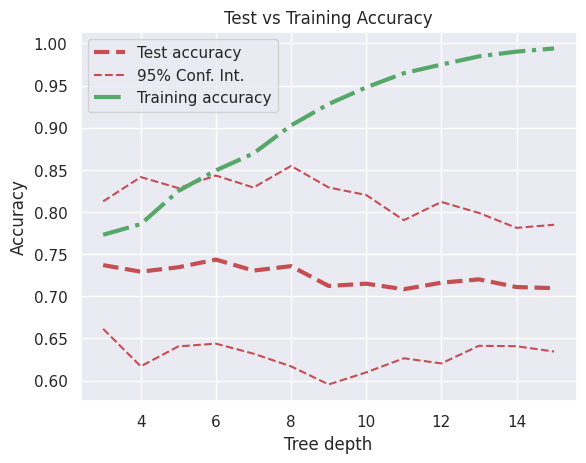

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plt.plot(tree_depths, test_means, 'r--', linewidth=3, label='Test accuracy')
plt.plot(tree_depths, np.array(test_means) + 2 * np.array(test_stdev), 
         'r--', label='95% Conf. Int.')
plt.plot(tree_depths, np.array(test_means) - 2 * np.array(test_stdev), 'r--')
plt.plot(tree_depths, training_means, 'g-.', linewidth = 3, 
         label = 'Training accuracy')

plt.xlabel('Tree depth')
plt.ylabel('Accuracy')
plt.title('Test vs Training Accuracy')
plt.legend()
plt.show()

# How does accuracy change as a function of dataset size?

In [ ]:
test_means = []
test_stdev = []
training_means = []
sample_sizes = list(range(20, 401, 20))
tree_depth = 8

for sample_size in sample_sizes:
    tree_clf = DecisionTreeClassifier(criterion='entropy', max_depth = tree_depth)
    scores = cross_validate(estimator = tree_clf, 
                            X = X[:sample_size], 
                            y = y[:sample_size], 
                            cv = 10, 
                            return_train_score = True)
    print('Sample size = {}, test accuracy: {:.3f}, 95% CI: ({:.3f}, {:.3f})'.format(
        sample_size, 
        np.mean(scores['test_score']), 
        np.mean(scores['test_score']) - 2 * np.std(scores['test_score']), 
        np.mean(scores['test_score']) + 2 * np.std(scores['test_score'])))
    print('\t      Training accuracy: {:.3f}'.format(np.mean(scores['train_score'])))
    test_means.append(np.mean(scores['test_score']))
    test_stdev.append(np.std(scores['test_score']))
    training_means.append(np.mean(scores['train_score']))

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(


Sample size = 20, test accuracy: 0.550, 95% CI: (-0.281, 1.381)
	      Training accuracy: 1.000
Sample size = 40, test accuracy: 0.800, 95% CI: (0.261, 1.339)
	      Training accuracy: 1.000
Sample size = 60, test accuracy: 0.500, 95% CI: (0.006, 0.994)
	      Training accuracy: 0.996
Sample size = 80, test accuracy: 0.637, 95% CI: (0.376, 0.899)
	      Training accuracy: 0.983
Sample size = 100, test accuracy: 0.660, 95% CI: (0.500, 0.820)
	      Training accuracy: 0.957
Sample size = 120, test accuracy: 0.625, 95% CI: (0.424, 0.826)
	      Training accuracy: 0.977
Sample size = 140, test accuracy: 0.614, 95% CI: (0.400, 0.828)
	      Training accuracy: 0.948
Sample size = 160, test accuracy: 0.681, 95% CI: (0.394, 0.969)
	      Training accuracy: 0.928
Sample size = 180, test accuracy: 0.683, 95% CI: (0.518, 0.849)
	      Training accuracy: 0.928
Sample size = 200, test accuracy: 0.715, 95% CI: (0.553, 0.877)
	      Training accuracy: 0.918
Sample size = 220, test accuracy: 0.695, 95

# Plot the results -- Learning curve

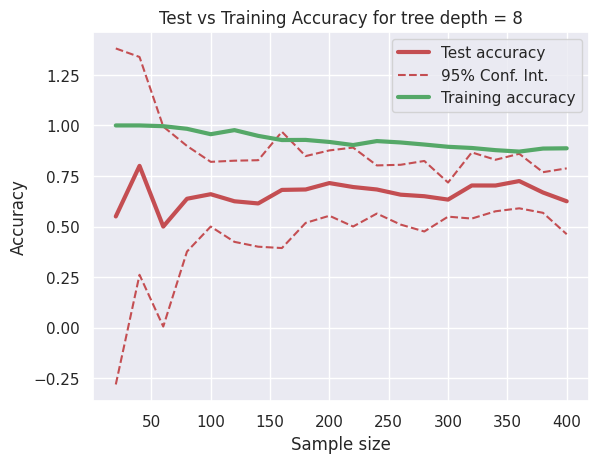

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plt.plot(sample_sizes, test_means, 'r-', linewidth=3, label='Test accuracy')
plt.plot(sample_sizes, np.array(test_means) + 2 * np.array(test_stdev), 
         'r--', label='95% Conf. Int.')
plt.plot(sample_sizes, np.array(test_means) - 2 * np.array(test_stdev), 'r--')
plt.plot(sample_sizes, training_means, 'g-', linewidth = 3, 
         label = 'Training accuracy')

plt.xlabel('Sample size')
plt.ylabel('Accuracy')
plt.title('Test vs Training Accuracy for tree depth = ' + str(tree_depth))
plt.legend()
plt.show()